# Homework # 2: Probability, Naive Bayes, and Linear Regression

# Question-1

### 1. From the training set, compute the total number of unique words in the set and the count of each unique word in each message. Hence, if there are N unique words and M messages in the training set, then the count of each unique word for all messages should result in a M × N matrix. You may want to use DataFrame and dictionary objects to accomplish this. You may also use split() to ignore whitespace.

In [2]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
def fetch_message_data():
    data=pd.read_csv("message.csv")
    return data

messages=fetch_message_data()

We require the StratifiedKFold to generate 10 folds of the entire dataset. Then we use train_test_split to split the dataset into 80-20 ratio as training and test set. Later to generate the confusion matrix of the classifier, we import confusion_matrix.

In [3]:
def create_word_matrix(X_train,y_train):
    unique=[]
    for i in X_train:
        words=i.split()
        for j in words:
            if j in unique:
                continue
            else:
                unique.append(j)


    word_dictionary={i:[0]*len(X_train) for i in unique}

    for j,message in enumerate(X_train):
        for l in message.split():
            word_dictionary[l][j]=word_dictionary[l][j]+1

    word_array=pd.DataFrame(word_dictionary)
    word_matrix=pd.concat([X_train,y_train,word_array],axis=1)
    
    return unique,word_matrix

We have defined a function named create_word_matrix(), which takes the input as X_train, which is the training data set containing the messages. We have also initialized a list named unique, which will store all the unique words from the current fold's training dataset. We use split functionality to remove white space. If the current word is present in unique, we ignore it, otherwise we append it to unique list.

To generate the word_matrix, we initially define an empty dictionay named: word_dictionary. This dictionary will hold the count of a particular word in the current message. We then create a new dataFrame named word_array with the above dictionary, and then concatenate the X_train and y_train to word_array and define and return a new DataFrame named word_matrix.

### 2. Perform maximum likelihood estimation to determine the prior and class conditional probabilities of the training set (e.g. compute P (y = 1), P (y = 0), P (x i |y = 0), and P (x i |y = 1)) ,where x i represents the i-th unique word. Be sure to confirm that these are indeed probabilities.
    

In [4]:
def calculate_priors_and_likelihoods(y_train,unique,word_matrix):

    spam_count=0
    not_spam_count=0
    for i in range(len(y_train)):
        if y_train[i]==0:
            not_spam_count+=1
        elif y_train[i]==1:
            spam_count+=1

    p_y_0=(not_spam_count/len(y_train))
    p_y_1=(spam_count/len(y_train))


    spam_mail=word_matrix[word_matrix["Label"]==1]
    spam_mail=spam_mail.reset_index(drop=True)
    
    len_spam_mail_words=0
    len_not_spam_mail_words=0
    
    for i in spam_mail["Message"]:
        c=i.split()
        len_spam_mail_words+=len(c)
    
    
    not_spam_mail=word_matrix[word_matrix["Label"]==0]
    not_spam_mail=not_spam_mail.reset_index(drop=True)
    
    for i in not_spam_mail["Message"]:
        c=i.split()
        len_not_spam_mail_words+=len(c)
    
    
    likelihood_spam={}
    likelihood_not_spam={}

    count=0

    for i in unique:
        count=spam_mail[i].sum()
        likelihood_spam[i]=(count/len_spam_mail_words)    
    
    for i in unique:
        count=not_spam_mail[i].sum()
        likelihood_not_spam[i]=(count/len_not_spam_mail_words)
    
    return p_y_0,p_y_1,likelihood_spam,likelihood_not_spam
    

We now begin with calculating the priors and likelihoods for the label training data set. P (y = 1) is stored in a variable p_y_1, which consists of the probabilty of getting a spam mail. The probabilty of a mail being spam, P(y=1) is equal to number of spam mails divided by total number of mails. Similarly P (y = 0) is stored in a variable p_y_0, which consists of the probabilty of getting a non-spam mail. The probabilty of a mail being non- spam, P(y=0) is equal to number of non-spam mails divided by total number of mails.

To calculate the likelihood of of a word being a part of a spam mail, we create a dataFrame named spam_mail, which consists of only the spam mails, i.e. with label=1. We then create a likelihood_spam dictionary, which will store the probability of a current word, given that y=1, i.e., if the mail is spam. The value of a key in the dictionary is sum of number of times the corresponding word occurs in spam mails divided by the total number of spam words. Total spam words are the words which belong to at least one spam mail, i.e. the total number of words present in spam mails.

P(Xi|y=1)=(count of Xi as spam)/(count of total spam words)
P(Xi|y=0)=(count of Xi as non-spam)/(count of total non spam words)

To calculate the likelihood of of a word being a part of a non spam mail, we create a dataFrame named not_spam_mail, which consists of only the non spam mails, i.e. with label=0. We then create a likelihood_not_spam dictionary, which will store the probability of a current word, given that y=0, i.e., if the mail is non spam. The value of a key in the dictionary is sum of number of times the corresponding word occurs in non spam mails divided by the total number of non-spam words.Total non-spam words are the words which belong to at least one non-spam mail, i.e. the total number of words present in non-spam mails.

To confirm that these values are actual probabilites, we have run this function on the last fold, where we can see that the values of the probabilities of all the words of the training data set of it being either a spam word or a non-spam word.

Thus we return all the values which are generated.

### 3. Once the above probabilities are determined, use Naive Bayes classification to classify each of the testing examples as spam or not. Ignore words from the testing set that are not contained in the training set. Report the accuracy, precision, recall and specificity, along with the confusion matrix for each fold. Also report the average accuracy, precision, recall and specificity over all folds.

In [5]:
def calculate_spam_probability_product(a,unique,likelihood_spam,p_y_1):
    a_word=a.split()
    prob=1.0
    for i in a_word:
        if i not in unique:
            prob=prob*1.0
        elif i in unique:
            if likelihood_spam[i]>0.0:
                prob=prob*(likelihood_spam[i])
            elif likelihood_spam[i]==0:
                prob=0.0
                break
                
     
    return prob*p_y_1


def calculate_not_spam_probability_product(a,unique,likelihood_not_spam,p_y_0):
    a_word=a.split()
    prob=1.0
    for i in a_word:
        if i not in unique:
            prob=prob*1.0
        elif i in unique:
            if likelihood_not_spam[i]>0.0:
                prob=prob*likelihood_not_spam[i]
            elif likelihood_not_spam[i]==0.0:
                prob=0.0
                break
            
    return prob*p_y_0


def classify(X_test,unique,likelihood_spam,likelihood_not_spam,p_y_0,p_y_1):
    y_pred=pd.DataFrame()
    y_pred['Label']=[0]*(len(X_test))
    for i in range(len(X_test)):
        not_spam_p=calculate_not_spam_probability_product(X_test[i],unique,likelihood_not_spam,p_y_0)
        spam_p=calculate_spam_probability_product(X_test[i],unique,likelihood_spam,p_y_1)
        
        if spam_p>not_spam_p:
            y_pred['Label'][i]=1
        else:
            y_pred['Label'][i]=0
            
    return y_pred

We now calculate the Posterior probability, given a particular message. We need to generate 2 posterior probabilities: One for Spam and one for non-Spam mails using 2 functions: calculate_spam_probability_product() and 
calculate_not_spam_probability_product()

We split the message from X_test dataset, to generate the words for it. We then apply the Bayes' theorem to calculate the Posterior probabilty.

P(y|x)=P(X|y)*P(y)/P(X)=P(X1|y)*P(X2|y)*...P(Xn|y)*P(y)/P(X)

For both P(y=0|X) and P(y=1|X), the value of P(X) will remain the same, hence there is no need to calculate it. Instead, we coud simply calculate P(X|y)*P(y) for y=0 and y=1.

We initialize a variable named prob to 1.0. We first check if the word is present in unique word list of training dataset. If it is not present, we simply continue further. If it is present in unique, it is possible that the P(Xi|y) could be 0.0. In such a case the product will always be 0.0, so we simply break the loop here. If the value is greater that 0.0, we multiply probability value from likelihood_spam(In case of spam mails), or with likelihood_not_spam(In case of non spam mails), with current prob value. We keep iterating till all the words of the test message are reached. We thus multiply the final prob with P(y=0) or p_y_0 in case of non spam mails, or with P(y=1) or p_y_1 in case of spam mails. Thus the calculate_spam_probability_product() will return P(X|y=1)*P(y=1) and calculate_not_spam_probability_product() will return P(X|y=0)*P(y=0).

In the classify() function, we now use the values returned from above 2 functions, and compare the 2 probability values. If spam_p is greater that not_spam_p, then we assign label on y_pred dataFrame for that particular index as 1, i.e. spam, otherwise we assign label on y_pred DataFrame for that particular index as 0, i.e. not spam. We eventually return the y_pred DataFrame for further evaluation. 

In [6]:
y_init=messages["Label"]
X_init=messages["Message"]
skf = StratifiedKFold(n_splits=10,random_state=42,shuffle=True)

sum_accuracy=0.0
sum_precision=0.0
sum_recall=0.0
sum_specificity=0.0


for i,j in enumerate(skf.split(X_init,y_init)):
    dummy,index=j
    X=X_init[index]
    y=y_init[index]
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
    X_train=X_train.reset_index(drop=True)
    y_train=y_train.reset_index(drop=True)
    X_test=X_test.reset_index(drop=True)
    y_test=y_test.reset_index(drop=True)
    
    y_test_df=pd.DataFrame()
    y_test_df['Label']=[0]*len(y_test)
    for e in range(len(y_test)):
        y_test_df['Label'][e]=y_test[e]
        
    unique,word_matrix=create_word_matrix(X_train,y_train)
    
    p_y_0,p_y_1,likelihood_spam,likelihood_not_spam=calculate_priors_and_likelihoods(y_train,unique,word_matrix)
    
    y_pred=classify(X_test,unique,likelihood_spam,likelihood_not_spam,p_y_0,p_y_1)

    conf_matrix=confusion_matrix(y_test_df,y_pred)
    tn=conf_matrix[0,0]
    fp=conf_matrix[0,1]
    fn=conf_matrix[1,0]
    tp=conf_matrix[1,1]
    print("\nConfusion Matrix for Fold ",i+1,"is:\n",conf_matrix)
    
    accuracy=(tp+tn)/(tp+fp+tn+fn)
    precision=tp/(tp+fp)
    recall=tp/(tp+fn)
    specificity=tn/(tn+fp)
    
    sum_accuracy=sum_accuracy+accuracy
    sum_precision=sum_precision+precision
    sum_recall=sum_recall+recall
    sum_specificity=sum_specificity+specificity
    
    
    print("Accuracy for Fold ",i+1,"is:",accuracy)
    print("Precision for Fold ",i+1,"is:",precision)
    print("Recall for Fold ",i+1,"is:",recall)
    print("Specificity for Fold ",i+1,"is:",specificity)
    
print("\nAverage accuracy is ", sum_accuracy/10)
print("Average precision is ",sum_precision/10)
print("Average recall is ",sum_recall/10)
print("Average Specificity is ",sum_specificity/10)



Confusion Matrix for Fold  1 is:
 [[98  0]
 [10  4]]
Accuracy for Fold  1 is: 0.9107142857142857
Precision for Fold  1 is: 1.0
Recall for Fold  1 is: 0.2857142857142857
Specificity for Fold  1 is: 1.0

Confusion Matrix for Fold  2 is:
 [[94  1]
 [12  5]]
Accuracy for Fold  2 is: 0.8839285714285714
Precision for Fold  2 is: 0.8333333333333334
Recall for Fold  2 is: 0.29411764705882354
Specificity for Fold  2 is: 0.9894736842105263

Confusion Matrix for Fold  3 is:
 [[92  2]
 [12  6]]
Accuracy for Fold  3 is: 0.875
Precision for Fold  3 is: 0.75
Recall for Fold  3 is: 0.3333333333333333
Specificity for Fold  3 is: 0.9787234042553191

Confusion Matrix for Fold  4 is:
 [[95  0]
 [ 8  9]]
Accuracy for Fold  4 is: 0.9285714285714286
Precision for Fold  4 is: 1.0
Recall for Fold  4 is: 0.5294117647058824
Specificity for Fold  4 is: 1.0

Confusion Matrix for Fold  5 is:
 [[89  2]
 [11 10]]
Accuracy for Fold  5 is: 0.8839285714285714
Precision for Fold  5 is: 0.8333333333333334
Recall for Fold

1. We now apply StratifiedKFold on the and make 10 folds of the entire dataset. We later iterate over the folds to generate the training and test datasets into 80-20 ratio. Thus we have 4 datasets generated per fold: X_train,X_test,y_train,y_test. After resetting their indices(to avoid ambiguity), we generate the pandas dataFrame version with Label as column for y_test named y_test_df for ease of calculation of Confusion Matrix.

2. We now call the create_word_matrix() function on X_train and y_test and return the unique words list and word_matrix.

3. We now call the calculate_priors_and_likelihoods() function on the training data set and generate the Priors and Likelihoods and we return them.

4. We then call the classify() function, which internally calls the calculate_spam_probability_product() and calculate_not_spam_probability_product(). The classify function returns the our predicted values, y_pred.

5. Based on the y_pred values and y_test_df values, we now generate the confusion matrix, and from here we can generate all the True Negatives, True Positives, False Positives and False Negatives and we assign them to the variables: tn,tp,fp and fn respectively.

6. Based on these values, we can calculate:
    accuracy=(tp+tn)/(tp+fp+tn+fn)
    precision=tp/(tp+fp)
    recall=tp/(tp+fn)
    specificity=tn/(tn+fp)
Also later we generate their average values over all folds.

### 4. Write a paragraph the summarizes the results and your thoughts about Naive Bayes classification for this problem

As we generated the Naive-Bayes Spam Classifier above using Bayes Theorem, we managed to achieve an average Accuracy of 89.64%, which is decent but not really great as we want least number of misclassifications. The accuracy is generated by adding the True Values(Positives and Negatives) and divide it by all the values of test dataset. The average Precision turns out to be around 89.50% which is also decent, but again we could have better. Precision basically gives us the ratio of True Positives to the total of True and False Positives, which means that the classifier can still perform better in classifying Spam mails(y=1) correctly. The biggest problem of the metrics is the average Recall value. This is shown to be about 37% which is bad. Recall gives us the ratio of True Postives to sum of all True Positives and False Negatives. Low recall value means that our classifier could still classify our spam mails as spam in a much more accurate way. The average Specificity is about 99%, because we do not have many negative samples classified as positive, hence the value is almost 100% accurate. Whenever the False Positives are 0, it causes our Precision and Specificity to be 100% for that particular fold. However, except fold 4 and 8, our Recall values are less 50%, which needs to improved drastically. The biggest reason behind the bad metric values is that the likelihood values of certain words which is 0, which causes our classifier to fail very badly. Whenever a word does not occur in any spam e-mail, but is present in test dataset, the P(Xi|y=1) will be 0, thereby causing the entire probability of the message being a spam to 0. So, irrespective of any other probability values of the message, the probability of that message of it being a spam is 0, and it is likely to get misclassified. The same issue occurs for non-spam emails as well. Another drawback of this method is, that if both the spam probability and not-spam probabilty of a message are 0, it by default gets assigned to be a non-spam message(because we have placed only if spam_p>not_spam_p for spam), so the case of spam_p==not_spam_p will classify it as non-spam, which might be inaccurate. 

To implement all the operations, we will be calling all the functions on one of the folds from above. 

In [7]:
sum_accuracy=0.0
sum_precision=0.0
sum_recall=0.0
sum_specificity=0.0


for i,j in enumerate(skf.split(X_init,y_init)):
    dummy,index=j
    X=X_init[index]
    y=y_init[index]
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
    X_train=X_train.reset_index(drop=True)
    y_train=y_train.reset_index(drop=True)
    X_test=X_test.reset_index(drop=True)
    y_test=y_test.reset_index(drop=True)
    
    y_test_df=pd.DataFrame()
    y_test_df['Label']=[0]*len(y_test)
    for e in range(len(y_test)):
        y_test_df['Label'][e]=y_test[e]
        
    unique,word_matrix=create_word_matrix(X_train,y_train)
    print("\nList of Unique words from X_train are:\n",unique)
    print("\nThe Corresponding Word Matrix storing count of each word in each mail is:\n",word_matrix)
    
    p_y_0,p_y_1,likelihood_spam,likelihood_not_spam=calculate_priors_and_likelihoods(y_train,unique,word_matrix)
    
    print("\nThe prior probability for Non spam mails is: ",p_y_0)
    print("\nThe prior probability for Spam mails is: ",p_y_1)
    print("\nThe likelihood values for each word in Non Spam mails are: ",likelihood_not_spam)
    print("\nThe likelihood values for each word in Spam mails are: ",likelihood_spam)

    
    y_pred=classify(X_test,unique,likelihood_spam,likelihood_not_spam,p_y_0,p_y_1)

    print("\nThe predicted classes are:\n",y_pred)
    print("\nThe actual values of y_test are:\n",y_test_df)
        
    conf_matrix=confusion_matrix(y_test_df,y_pred)
    tn=conf_matrix[0,0]
    fp=conf_matrix[0,1]
    fn=conf_matrix[1,0]
    tp=conf_matrix[1,1]
    print("\nConfusion Matrix for Fold ",i+1,"is:\n",conf_matrix)
    
    accuracy=(tp+tn)/(tp+fp+tn+fn)
    precision=tp/(tp+fp)
    recall=tp/(tp+fn)
    specificity=tn/(tn+fp)
    
    sum_accuracy=sum_accuracy+accuracy
    sum_precision=sum_precision+precision
    sum_recall=sum_recall+recall
    sum_specificity=sum_specificity+specificity
    
    
    print("Accuracy for Fold ",i+1,"is:",accuracy)
    print("Precision for Fold ",i+1,"is:",precision)
    print("Recall for Fold ",i+1,"is:",recall)
    print("Specificity for Fold ",i+1,"is:",specificity)
    
    break
    



List of Unique words from X_train are:
 ['was', 'gr8', 'to', 'see', 'that', 'message', 'so', 'when', 'r', 'u', 'leaving', 'congrats', 'dear', 'what', 'school', 'and', 'wat', 'ur', 'plans', 'boooo', 'you', 'always', 'work', 'just', 'quit', 'ok', 'oh', 'a', 'half', 'hour', 'is', 'much', 'longer', 'in', 'syria', 'than', 'canada', 'eh', 'wow', 'must', 'get', 'more', 'done', 'day', 'us', 'with', 'all', 'extra', 'time', 'grins', 'call', 'him', 'now', 'i', 'said', 'perhaps', 'easy', 'give', 'your', 'account', 'identification', 'will', 'tomorrow', 'at', 'uni', 'hope', 'head', 'doesn', 't', 'hurt', '2', 'am', 'ploughing', 'my', 'way', 'through', 'pile', 'of', 'ironing', 'staying', 'chinky', 'tonight', 'come', 'round', 'if', 'like', 'good', 'afternoon', 'boytoy', 'how', 'are', 'feeling', 'today', 'better', 'being', 'boy', 'obedient', 'slave', 'do', 'please', 'queen', 'free', 'msg', 'sorry', 'service', 'ordered', 'from', '81303', 'could', 'not', 'be', 'delivered', 'as', 'have', 'sufficient', 'cr


The prior probability for Non spam mails is:  0.8632286995515696

The prior probability for Spam mails is:  0.1367713004484305

The likelihood values for each word in Non Spam mails are:  {'was': 0.0030986400413152006, 'gr8': 0.0005164400068858667, 'to': 0.019280426923739026, 'see': 0.0013771733516956446, 'that': 0.009295920123945601, 'message': 0.0015493200206576003, 'so': 0.006025133413668445, 'when': 0.0048201067309347565, 'r': 0.0012050266827336891, 'u': 0.011189533482527114, 'leaving': 0.00034429333792391115, 'congrats': 0.00017214666896195557, 'dear': 0.001721466689619556, 'what': 0.0025822000344293337, 'school': 0.0005164400068858667, 'and': 0.010673093475641247, 'wat': 0.0013771733516956446, 'ur': 0.003442933379239112, 'plans': 0.00034429333792391115, 'boooo': 0.00017214666896195557, 'you': 0.027887760371836805, 'always': 0.0013771733516956446, 'work': 0.0013771733516956446, 'just': 0.0036150800482010674, 'quit': 0.00017214666896195557, 'ok': 0.0030986400413152006, 'oh': 0.002

5. One problem with Naive Bayes classification is that the class conditional probabilities for each feature P (x i |y) may be zero in many cases. This is a result of using limited data. One way to correct this is to “smooth” the values when computing the probabilities, where Laplace smoothing is one approach.

Assuming z is a random variable that has G different possible outcomes, then the conditional probability of z given y can be calculated as below when using Laplace Smoothing:

P (z = g|y = 0) = (n g + 1)/(n + G)

n g is the total number of times z = g when y = 0, n is the total number of examples when y = 0.
Repeat steps 2-4 from above, where Laplace Smoothing is used when calculating the class
conditional probabilities for each word. Discuss how the results after Laplace Smoothing differ
from the prior results.

In [8]:
def calculate_priors_and_likelihoods_laplace(y_train,unique,word_matrix):

    spam_count=0
    not_spam_count=0
    for i in range(len(y_train)):
        if y_train[i]==0:
            not_spam_count+=1
        elif y_train[i]==1:
            spam_count+=1

    p_y_0=(not_spam_count/len(y_train))
    p_y_1=(spam_count/len(y_train))


    spam_mail=word_matrix[word_matrix["Label"]==1]
    spam_mail=spam_mail.reset_index(drop=True)
    
    len_spam_mail_words=0
    len_not_spam_mail_words=0
    
    for i in spam_mail["Message"]:
        c=i.split()
        len_spam_mail_words+=len(c)
    
    
    not_spam_mail=word_matrix[word_matrix["Label"]==0]
    not_spam_mail=not_spam_mail.reset_index(drop=True)
    
    for i in not_spam_mail["Message"]:
        c=i.split()
        len_not_spam_mail_words+=len(c)

    likelihood_spam={}
    likelihood_not_spam={}

    count=0

    for i in unique:
        count=spam_mail[i].sum()
        likelihood_spam[i]=(count+1)/(len_spam_mail_words+len(unique))

    for i in unique:
        count=not_spam_mail[i].sum()
        likelihood_not_spam[i]=(count+1)/(len_not_spam_mail_words+len(unique))
       
    return p_y_0,p_y_1,likelihood_spam,likelihood_not_spam

In Laplace Transformation, most of the operations from above are similar, except for the calculation of Likelihood probabilites. For any value, we calculate the probability using the formula:

P (z = g|y = 0) = (ng + 1)/(n + G)

where,

ng is the total number of times z = g and G is total number of outcomes of z.

In terms of P(Xi|y), we have the Laplace transform as follows:

P(Xi|y=0)=(Number of times Xi occurs in Non Spam mails + 1) / (Number of words in all non spam mails+Number of Unique words in the data set)

P(Xi|y=1)=(Number of times Xi occurs in Spam mails + 1) / (Number of words in all spam mails+Number of Unique words in the data set)

The advantage of using above transform is that, we can now choose a value with initial likelihood 0 as well, as we add 1 in the numerator. So this time the likelihood value of any word is always greater than zero, thus it should solve our initial problem and increase our classifier's accuracy. We are balancing the numerator by adding the length of total number of unique words as well. Thus we get a smoother value of likelihoods.

In [9]:
y_init_new=messages["Label"]
X_init_new=messages["Message"]
skf = StratifiedKFold(n_splits=10,random_state=42,shuffle=True)

sum_accuracy=0.0
sum_precision=0.0
sum_recall=0.0
sum_specificity=0.0

for i,j in enumerate(skf.split(X_init_new,y_init_new)):
    dummy,index=j
    X=X_init_new[index]
    y=y_init_new[index]
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
    X_train=X_train.reset_index(drop=True)
    y_train=y_train.reset_index(drop=True)
    X_test=X_test.reset_index(drop=True)
    y_test=y_test.reset_index(drop=True)
    
    y_test_df=pd.DataFrame()
    y_test_df['Label']=[0]*len(y_test)
    for e in range(len(y_test)):
        y_test_df['Label'][e]=y_test[e]
        
    unique,word_matrix=create_word_matrix(X_train,y_train)
    
    p_y_0,p_y_1,likelihood_spam_laplace,likelihood_not_spam_laplace=calculate_priors_and_likelihoods_laplace(y_train,unique,word_matrix)
    
    y_pred_laplace=classify(X_test,unique,likelihood_spam_laplace,likelihood_not_spam_laplace,p_y_0,p_y_1)

    conf_matrix_laplace=confusion_matrix(y_test_df,y_pred_laplace)
    tn=conf_matrix_laplace[0,0]
    fp=conf_matrix_laplace[0,1]
    fn=conf_matrix_laplace[1,0]
    tp=conf_matrix_laplace[1,1]
    print("\nConfusion Matrix for Fold ",i+1,"is:\n",conf_matrix_laplace)
    
    accuracy=(tp+tn)/(tp+fp+tn+fn)
    precision=tp/(tp+fp)
    recall=tp/(tp+fn)
    specificity=tn/(tn+fp)
    
    sum_accuracy=sum_accuracy+accuracy
    sum_precision=sum_precision+precision
    sum_recall=sum_recall+recall
    sum_specificity=sum_specificity+specificity

    print("Accuracy for Fold ",i+1,"is:",accuracy)
    print("Precision for Fold ",i+1,"is:",precision)
    print("Recall for Fold ",i+1,"is:",recall)
    print("Specificity for Fold ",i+1,"is:",specificity)
    
print("\nAverage accuracy is ", sum_accuracy/10)
print("Average precision is ",sum_precision/10)
print("Average recall is ",sum_recall/10)
print("Average Specificity is ",sum_specificity/10)
    


Confusion Matrix for Fold  1 is:
 [[98  0]
 [ 3 11]]
Accuracy for Fold  1 is: 0.9732142857142857
Precision for Fold  1 is: 1.0
Recall for Fold  1 is: 0.7857142857142857
Specificity for Fold  1 is: 1.0

Confusion Matrix for Fold  2 is:
 [[95  0]
 [ 5 12]]
Accuracy for Fold  2 is: 0.9553571428571429
Precision for Fold  2 is: 1.0
Recall for Fold  2 is: 0.7058823529411765
Specificity for Fold  2 is: 1.0

Confusion Matrix for Fold  3 is:
 [[94  0]
 [ 3 15]]
Accuracy for Fold  3 is: 0.9732142857142857
Precision for Fold  3 is: 1.0
Recall for Fold  3 is: 0.8333333333333334
Specificity for Fold  3 is: 1.0

Confusion Matrix for Fold  4 is:
 [[95  0]
 [ 3 14]]
Accuracy for Fold  4 is: 0.9732142857142857
Precision for Fold  4 is: 1.0
Recall for Fold  4 is: 0.8235294117647058
Specificity for Fold  4 is: 1.0

Confusion Matrix for Fold  5 is:
 [[91  0]
 [ 1 20]]
Accuracy for Fold  5 is: 0.9910714285714286
Precision for Fold  5 is: 1.0
Recall for Fold  5 is: 0.9523809523809523
Specificity for Fold  

1. The other operations will remain the same, there is no need to create a new classify() or calculate_spam_probability_product() or calculate_not_spam_probability_product() function, as we can recall the same with Laplace transformed inputs. So we initially generate 10 folds, split each fold into 80-20 ration for Training and Test dataset.

2. We now call the create_word_matrix() function on X_train and y_test and return the unique words list and word_matrix.

3. We now call the calculate_priors_and_likelihoods_laplace() function on the training data set and generate the Priors and Likelihoods using Laplace transform and we return likelihood_spam_laplace and likelihood_not_spam_laplace dictionaries.

4. We then call the classify() function, which internally calls the calculate_spam_probability_product() and calculate_not_spam_probability_product(). The classify function returns the our predicted values, y_pred_laplace. In the classify() function, we have passed the likelihood_spam_laplace and likelihood_not_spam_laplace values.

5. Based on the y_pred_laplace values and y_test_df values, we now generate the confusion matrix, and from here we can generate all the True Negatives, True Positives, False Positives and False Negatives and we assign them to the variables: tn,tp,fp and fn respectively.

6. Based on these values, we can calculate:
    accuracy=(tp+tn)/(tp+fp+tn+fn)
    precision=tp/(tp+fp)
    recall=tp/(tp+fn)
    specificity=tn/(tn+fp)
Also later we generate their average values over all folds.

To see the output of all operations on one of the folds, we have added print statement for every value:

In [10]:
sum_accuracy=0.0
sum_precision=0.0
sum_recall=0.0
sum_specificity=0.0


for i,j in enumerate(skf.split(X_init,y_init)):
    dummy,index=j
    X=X_init[index]
    y=y_init[index]
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)
    X_train=X_train.reset_index(drop=True)
    y_train=y_train.reset_index(drop=True)
    X_test=X_test.reset_index(drop=True)
    y_test=y_test.reset_index(drop=True)
    
    y_test_df=pd.DataFrame()
    y_test_df['Label']=[0]*len(y_test)
    for e in range(len(y_test)):
        y_test_df['Label'][e]=y_test[e]
        
    unique,word_matrix=create_word_matrix(X_train,y_train)
    print("\nList of Unique words from X_train are:\n",unique)
    print("\nThe Corresponding Word Matrix storing count of each word in each mail is:\n",word_matrix)
    
    p_y_0,p_y_1,likelihood_spam_laplace,likelihood_not_spam_laplace=calculate_priors_and_likelihoods_laplace(y_train,unique,word_matrix)
    
    print("\nThe prior probability for Non spam mails is: ",p_y_0)
    print("\nThe prior probability for Spam mails is: ",p_y_1)
    print("\nThe likelihood values for each word in Non Spam mails after Laplace Transform are: ",likelihood_not_spam_laplace)
    print("\nThe likelihood values for each word in Spam mails after Laplace Transform are: ",likelihood_spam_laplace)

    
    y_pred_laplace=classify(X_test,unique,likelihood_spam_laplace,likelihood_not_spam_laplace,p_y_0,p_y_1)

    print("\nThe predicted classes after Laplace Transform are:\n",y_pred_laplace)
    print("\nThe actual values of y_test are:\n",y_test_df)
        
    conf_matrix_laplace=confusion_matrix(y_test_df,y_pred_laplace)
    tn=conf_matrix[0,0]
    fp=conf_matrix[0,1]
    fn=conf_matrix[1,0]
    tp=conf_matrix[1,1]
    print("\nConfusion Matrix for Fold ",i+1,"is:\n",conf_matrix_laplace)
    
    accuracy=(tp+tn)/(tp+fp+tn+fn)
    precision=tp/(tp+fp)
    recall=tp/(tp+fn)
    specificity=tn/(tn+fp)
    
    sum_accuracy=sum_accuracy+accuracy
    sum_precision=sum_precision+precision
    sum_recall=sum_recall+recall
    sum_specificity=sum_specificity+specificity
    
    
    print("Accuracy after Laplace Transform for Fold ",i+1,"is:",accuracy)
    print("Precision after Laplace Transform for Fold ",i+1,"is:",precision)
    print("Recall after Laplace Transform for Fold ",i+1,"is:",recall)
    print("Specificity after Laplace Transform for Fold ",i+1,"is:",specificity)
    
    break


List of Unique words from X_train are:
 ['was', 'gr8', 'to', 'see', 'that', 'message', 'so', 'when', 'r', 'u', 'leaving', 'congrats', 'dear', 'what', 'school', 'and', 'wat', 'ur', 'plans', 'boooo', 'you', 'always', 'work', 'just', 'quit', 'ok', 'oh', 'a', 'half', 'hour', 'is', 'much', 'longer', 'in', 'syria', 'than', 'canada', 'eh', 'wow', 'must', 'get', 'more', 'done', 'day', 'us', 'with', 'all', 'extra', 'time', 'grins', 'call', 'him', 'now', 'i', 'said', 'perhaps', 'easy', 'give', 'your', 'account', 'identification', 'will', 'tomorrow', 'at', 'uni', 'hope', 'head', 'doesn', 't', 'hurt', '2', 'am', 'ploughing', 'my', 'way', 'through', 'pile', 'of', 'ironing', 'staying', 'chinky', 'tonight', 'come', 'round', 'if', 'like', 'good', 'afternoon', 'boytoy', 'how', 'are', 'feeling', 'today', 'better', 'being', 'boy', 'obedient', 'slave', 'do', 'please', 'queen', 'free', 'msg', 'sorry', 'service', 'ordered', 'from', '81303', 'could', 'not', 'be', 'delivered', 'as', 'have', 'sufficient', 'cr


The prior probability for Non spam mails is:  0.8632286995515696

The prior probability for Spam mails is:  0.1367713004484305

The likelihood values for each word in Non Spam mails after Laplace Transform are:  {'was': 0.00240750126710593, 'gr8': 0.0005068423720223011, 'to': 0.014318297009630006, 'see': 0.0011403953370501775, 'that': 0.0069690826153066395, 'message': 0.0012671059300557526, 'so': 0.00456158134820071, 'when': 0.0036746071971616827, 'r': 0.0010136847440446021, 'u': 0.008362899138367968, 'leaving': 0.0003801317790167258, 'congrats': 0.00025342118601115053, 'dear': 0.001393816523061328, 'what': 0.0020273694880892043, 'school': 0.0005068423720223011, 'and': 0.007982767359351241, 'wat': 0.0011403953370501775, 'ur': 0.0026609224531170808, 'plans': 0.0003801317790167258, 'boooo': 0.00025342118601115053, 'you': 0.020653826659908767, 'always': 0.0011403953370501775, 'work': 0.0011403953370501775, 'just': 0.002787633046122656, 'quit': 0.00025342118601115053, 'ok': 0.002407501267

# Report after using Laplace Transform.

As we saw from above, the biggest advantage of using Laplace transform is that if likelihood probability of any word is 0, then it can be smoothed by adding 1 and dividing it by the number of category words(y=0 or y=1, depending on which condition is the probability being evaluated) + the length of number of unique words in the training data set. This addition to the denominator will normalize the addition of 1 in the numerator. As we can see from the metric values, they have increase and improved drastically. As we can see from above, there is no likelihood probability value which is of value 0, all of them get updated to a smoother value. Thus, no longer will our spam product or non spam product crash to 0. Our average accuracy has now increased to 96.875%, our average precision and average specificity is almost 100%, as we have only 1 False positive throughout the testing dataset. The best improvement though is in the Recall value, as it increases from 37% to 80% after Laplace transform. Due to replacement with non-zero probability values, we now get a more accurate classifier. Thus it is better to apply Laplace Transform to improve the performance of our Naive Bayes classifier. 

# Question-2

In [1]:
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import pandas as pd
import numpy as np
import math
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import seaborn as sb
from scipy.stats.stats import pearsonr
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

In [2]:
# Function to load the data
# def load_file(file_name):
#   Cov = pd.read_csv(file_name, sep='\t')
#   dfm = pd.DataFrame(Cov.values, columns = ["satisfaction", "age", "severity", "anxiety_level"])
#   return dfm.to_csv(file_name, sep='\t')
def load_file(file_name):
  dfm = pd.read_fwf(file_name, names = ["satisfaction", "age", "severity", "anxiety_level"])
  return dfm

Reference for the read_fwf() pandas library - read_fwf

In [3]:
# Get to know about the data
dfm = load_file('patient_satisfaction.txt')
dfc = dfm.copy()
dfc.head()

,satisfaction,age,severity,anxiety_level
0,48,50,51,2.3
1,57,36,46,2.3
2,66,40,48,2.2
3,70,41,44,1.8
4,89,28,43,1.8


In [4]:
# Data Information
dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   satisfaction   46 non-null     int64  
 1   age            46 non-null     int64  
 2   severity       46 non-null     int64  
 3   anxiety_level  46 non-null     float64
dtypes: float64(1), int64(3)
memory usage: 1.6 KB


Reference for scatterplots - [Seaborn](https://www.youtube.com/watch?v=4yz4cMXCkuw)

### 1. Generate scatter plots between each of the features  and label. Also   compute the correlation coeficients between each feature-label pair. What do the scatter plots and correlations convey about the dierent relationships?

<AxesSubplot:xlabel='age', ylabel='satisfaction'>

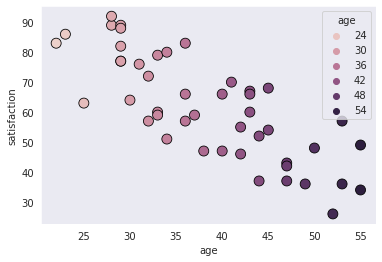

In [5]:
# Create a scatterplot
sb.set_style('dark')
sb.scatterplot(x='age', y='satisfaction', hue='age', edgecolor='black', data=dfc, s=100)

<AxesSubplot:xlabel='severity', ylabel='satisfaction'>

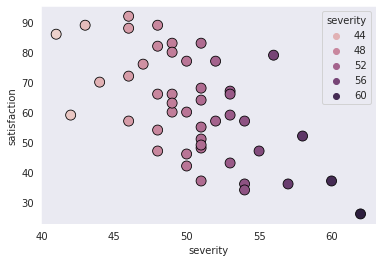

In [6]:
# Create a scatterplot
sb.set_style('dark')
sb.scatterplot(x='severity', y='satisfaction', hue='severity', edgecolor='black', data=dfc, s=100)

<AxesSubplot:xlabel='anxiety_level', ylabel='satisfaction'>

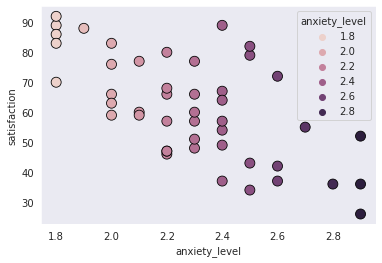

In [7]:
# Create a scatterplot
sb.set_style('dark')
sb.scatterplot(x='anxiety_level', y='satisfaction', hue='anxiety_level', edgecolor='black', data=dfc, s=100)

In [8]:
# Correlation Coefficient
def cor_cof(df):
  res_verify = {}
  attrs = ['age', 'severity', 'anxiety_level']
  for x in attrs:
    res_cor_verify = []
    pearsonr_coefficient, p_value = pearsonr(df['satisfaction'], df[x])
    res_cor_verify.append(round(pearsonr_coefficient, 5))
    res_verify[x] = res_cor_verify
  return res_verify

In [9]:
# Get the correlation coefficients
cor_cof(dfm)

{'age': [-0.78676], 'severity': [-0.60294], 'anxiety_level': [-0.64459]}

In [10]:
# Verify with corr
coef = {}
coef = cor_cof(dfm)
for corr in coef:
    print("Correlation coefficients between y and", corr , "is", coef[corr])

# built-in function, to cross verify
corr_matrix = dfm.corr()
print("\n")
print(corr_matrix["satisfaction"])

Correlation coefficients between y and age is [-0.78676]
Correlation coefficients between y and severity is [-0.60294]
Correlation coefficients between y and anxiety_level is [-0.64459]


satisfaction     1.000000
age             -0.786756
severity        -0.602942
anxiety_level   -0.644591
Name: satisfaction, dtype: float64


y = satisfaction
x = age, severity, anxiety_level

The Correlation coefficients between y=satisfaction and x is -0.786756. It is close to -1, it means that there is a strong negative correlation between x and y. There’s an inverse relationship between patient’s age,severity,anxiety_level  and patient’s satisfaction with the hospital. There’s an inverse relationship between anxiety level and patient’s satisfaction with the hospital.

### 2. Divide this data into K=10 folds of training and testing sets. Using your own implementations of batch, stochastic and mini-batch gradient descent, fit a linear regression model using the training data. Generate plots of the training loss for each iteration and implementation. Experiment with different values for the learning rate and mini-batch size. Discuss how you selected the optimal values for the learning rate and mini-batch size. Display the final regression coefficients for each implementation.

### 3. Once trained, use the testing data and mean-square error to evaluate performance. Which approach performed best? Why?

Gradient Descent reference from this blog - [Medium](https://medium.com/@lope.ai/multivariate-linear-regression-from-scratch-in-python-5c4f219be6a)

In [11]:
# Scale and standardize the features
X = dfc[[i for i in dfc.columns if i != "satisfaction"]].to_numpy()
Y = dfc["satisfaction"].to_numpy()
sc = StandardScaler()
X = sc.fit_transform(X)

In [12]:
# Split training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
kf = KFold(n_splits=10, shuffle=True, random_state=43)
kf

KFold(n_splits=10, random_state=43, shuffle=True)

In [13]:
# # Batch Gradient Descent
def batch_gradient_descent(X, Y, learning_rate=0.1, iter=1000):

  loss = []
  b = 0
  nf = X.shape[1]
  nr = X.shape[0]

  # random initialization
  cost = np.random.rand(nf)

  for it in range(iter):
    y_h = np.dot(cost, X.T) + b
    if it == 0:
      mse_b = 99999999
    p_mse = mse_b
    mse_b = mean_squared_error(Y, y_h)

    if mse_b < p_mse:
      cost = cost - (-(2/nr) * (X.T.dot(Y-y_h))) * learning_rate
      b = b - (-(2/nr) * np.sum(Y - y_h)) * learning_rate
    loss.append(mse_b)
  return b, cost, loss

In [14]:
def predict_trgt(x1, x2, x3, cost, b):
    xf = x_min_max.transform([[x1, x2, x3]])[0]
    yt =  cost[0] * xf[0] + cost[1] * xf[1] + cost[2] * xf[2] + b
    pval =  y_min_max.inverse_transform([[yt]])[0][0]
    return pval

KFold: 1


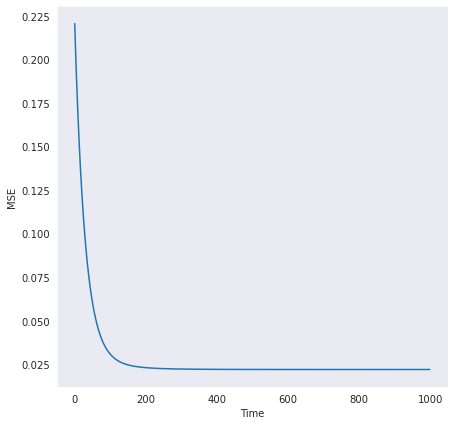

MSE: 24.88975096003791 

KFold: 2


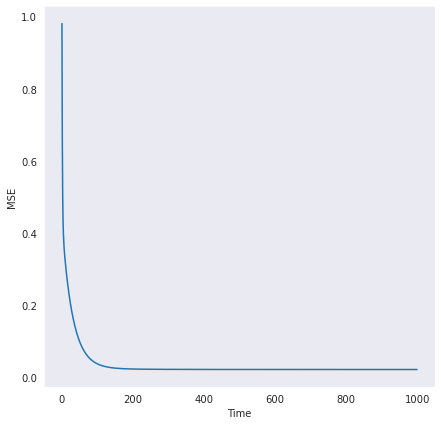

MSE: 3.6091335722997373 

KFold: 3


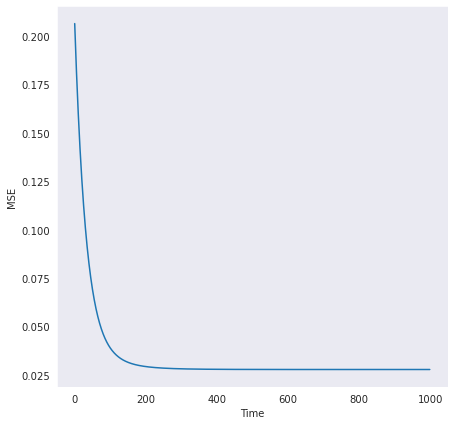

MSE: 2.030119871370439 

KFold: 4


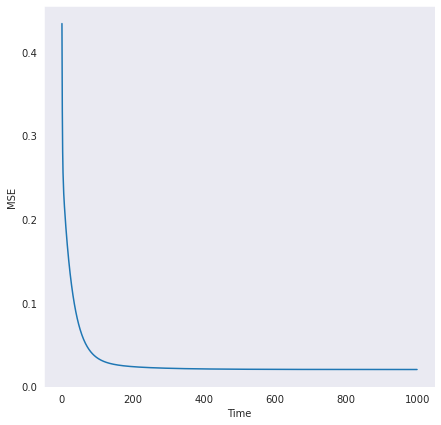

MSE: 2.3225238682269835 

KFold: 5


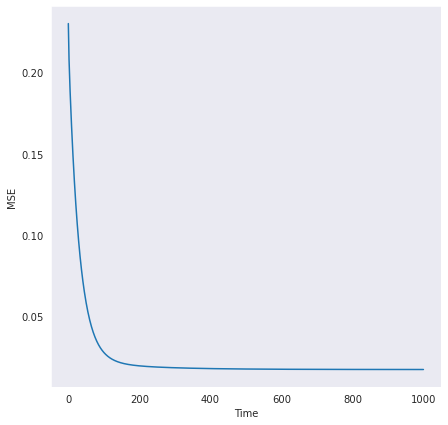

MSE: 42.02909919381583 

KFold: 6


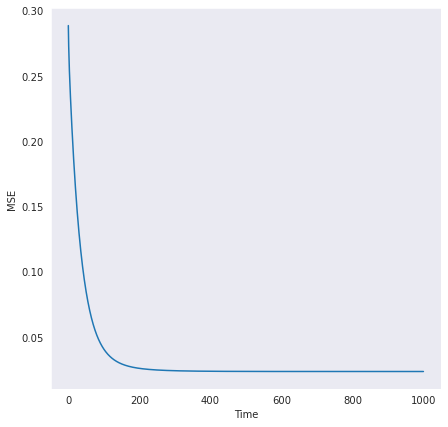

MSE: 26.68602131142302 

KFold: 7


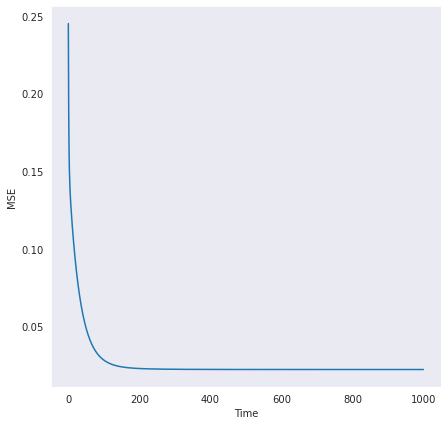

MSE: 12.893873203936863 

KFold: 8


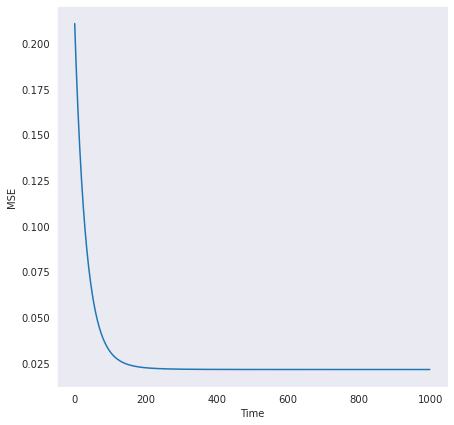

MSE: 6.912120121670845 

KFold: 9


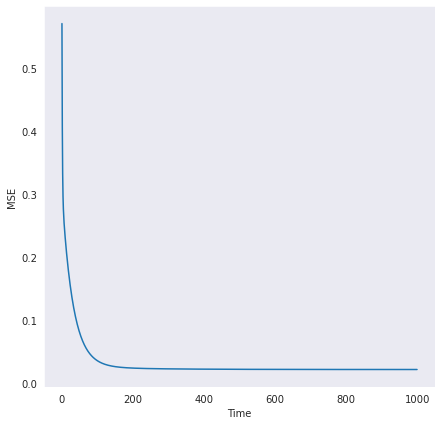

MSE: 70.21004131780238 

KFold: 10


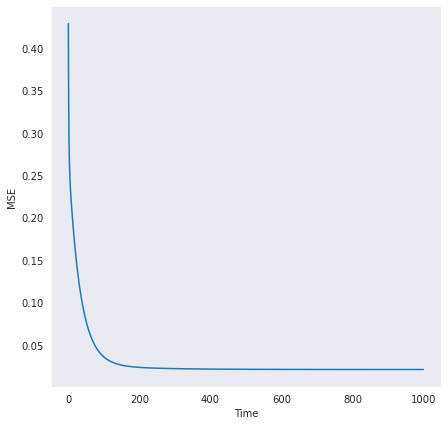

MSE: 33.490303859127934 



Average mse after kFold: 22.507298727971193


In [21]:
avg_mean_sq = 0
ct = 0
fold = 0
for train_index, test_index in kf.split(dfm):
    fold += 1
    train_set = dfm.loc[train_index]
    test_set = dfm.loc[test_index]
    x_min_max = preprocessing.MinMaxScaler()
    y_min_max = preprocessing.MinMaxScaler()
    x_features = x_min_max.fit_transform(train_set.drop('satisfaction', axis='columns'))
    y_target = y_min_max.fit_transform(train_set['satisfaction'].values.reshape(train_set.shape[0],1))
    y_target = y_target.reshape(y_target.shape[0],)
    learning_rate = 0.01
    b, cost, loss = batch_gradient_descent(x_features, y_target)
    l = list(range(1000))
    print(f"KFold: {fold}")
    plt.figure(figsize=(7,7))
    plt.ylabel('MSE')
    plt.xlabel('Time')
    plt.plot(l, loss)
    plt.show()
    
    for tpd in test_set.values:
        msq = []
        pred = predict_trgt(tpd[1], tpd[2], tpd[3], cost, b)
        msq_err = (tpd[0] - pred) ** 2
        msq.append(msq_err)
    mse = sum(msq) / len(test_set)
    avg_mean_sq += mse
    print(f"MSE: {mse}", "\n")
    ct += 1
print("\n")
print("Average mse after kFold:", avg_mean_sq / ct)

In [16]:
def stochastic_gd(xfeat, y_tar, learning_rate, itr):
    clst = []
    bais = 0
    nfeatures = xfeat.shape[1]
    no_records = xfeat.shape[0] 
    weight = np.ones(shape=nfeatures)
    for i in range(itr):
        indx = random.randint(0,no_records-1)
        xStoch = xfeat[indx]
        yStoch = y_tar[indx]
        pred_y = np.dot(weight, xStoch.T) + bais
        if i == 0:
            mse_stoch = 99999999
        prev_mse_stoch = mse_stoch
        mse_stoch = np.mean(np.square(yStoch-pred_y)) 
        if mse_stoch < prev_mse_stoch:
            weight = weight -  (-(2/no_records)*(xStoch.T.dot(yStoch-pred_y))) * learning_rate
            bais = bais - (-(2/no_records)*np.sum(yStoch-pred_y)) * learning_rate
        clst.append(mse_stoch)
    return bais,weight,clst

Fold: 1 training loss


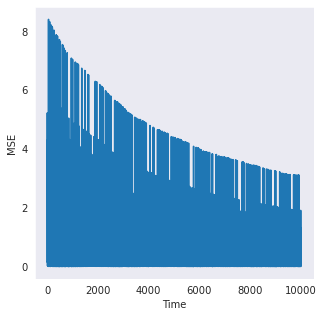

Mean square error 55.7957263869 

Fold: 2 training loss


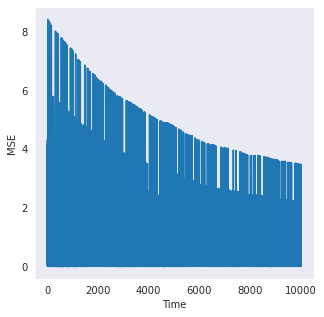

Mean square error 91.239846882342 

Fold: 3 training loss


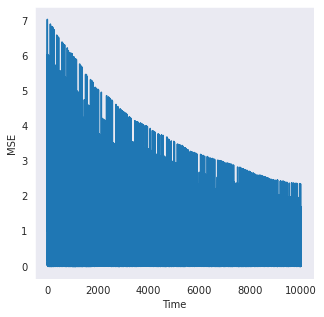

Mean square error 471.42892930812224 

Fold: 4 training loss


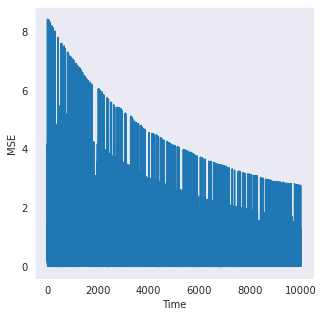

Mean square error 1.8728676265023627 

Fold: 5 training loss


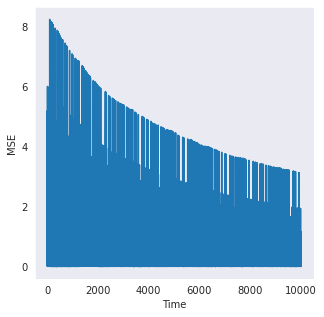

Mean square error 622.9376645521852 

Fold: 6 training loss


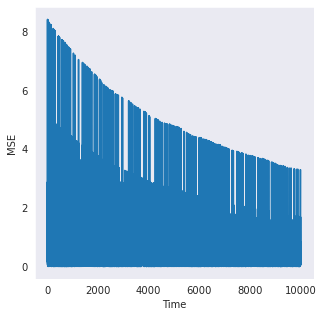

Mean square error 907.6233592217919 

Fold: 7 training loss


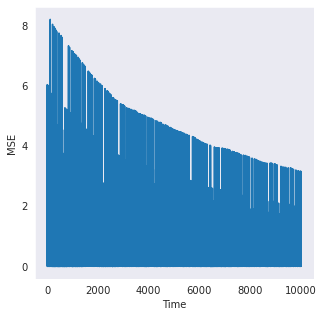

Mean square error 700.8448642439674 

Fold: 8 training loss


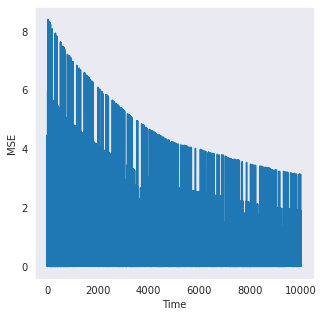

Mean square error 13.612872801183295 

Fold: 9 training loss


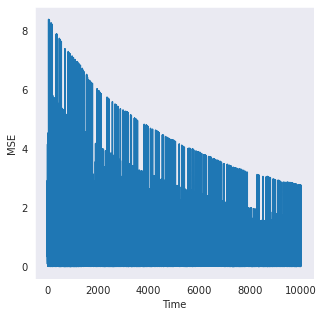

Mean square error 262.24097032422037 

Fold: 10 training loss


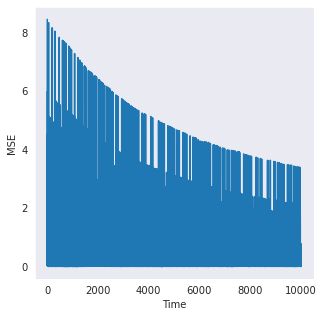

Mean square error 1379.0146017402553 



Average mean square error after 10 folds: 450.66117030874705


In [17]:
#stochastic 
import random
avg_mean_sq = 0
c = 0
fld = 0
for train_index, test_index in kf.split(dfm):
    fld += 1
    pat_train_set = dfm.loc[train_index] #training data
    pat_test_set = dfm.loc[test_index] #test data
    fminMax = preprocessing.MinMaxScaler()
    tminMax = preprocessing.MinMaxScaler()
    xFeatures = fminMax.fit_transform(pat_train_set.drop('satisfaction',axis='columns'))
    yTarget = tminMax.fit_transform(pat_train_set['satisfaction'].values.reshape(pat_train_set.shape[0],1))
    yTarget = yTarget.reshape(yTarget.shape[0],)
    learning_rate = 0.01
    bais,weight,clst= stochastic_gd(xFeatures,yTarget,learning_rate,10000)
    lst = list(range(10000))
    print("Fold:", fld, "training loss")
    plt.figure(figsize=(5,5))
    plt.ylabel('MSE')
    plt.xlabel('Time')
    plt.plot(lst,clst)
    plt.show()
    
    for test_pred in pat_test_set.values:
        mean_sq = []
        pred = predict_trgt(test_pred[1], test_pred[2], test_pred[3],weight,bais)
        m_err = (test_pred[0] - pred) ** 2
        mean_sq.append(m_err)
    mse = sum(mean_sq)/len(pat_test_set)
    avg_mean_sq += mse
    print("Mean square error", mse, "\n")
    c+=1
print("\n")   
print("Average mean square error after 10 folds:",avg_mean_sq/c)

In [18]:
# Mini batch
def minibatch_gd(X, Y, learning_rate, itr, batch):
    clst = []
    bais = 0
    nf = X.shape[1]
    nr = X.shape[0]
    cost = np.ones(shape=nf)
    if nr < batch:
        batch = nr
    for i in range(itr): 
        indx = np.random.permutation(nr)
        xMini = X[indx]
        yMini = Y[indx]
        for b in range(0,nr,batch):
            xMiniBatch = xMini[b:b+batch]
            yMiniBatch = yMini[b:b+batch]
            pred_y = np.dot(weight, xMiniBatch.T) + bais
            if i == 0:
                mse_minibatch = 99999999
            prev_mse_minibatch = mse_minibatch
            mse_minibatch = np.mean(np.square(yMiniBatch-pred_y)) 
            if mse_minibatch < prev_mse_minibatch:
                cost = cost -  (-(2/len(xMiniBatch))*(xMiniBatch.T.dot(yMiniBatch-pred_y))) * learning_rate
                bais = bais - (-(2/len(xMiniBatch))*np.sum(yMiniBatch-pred_y)) * learning_rate
            clst.append(mse_minibatch)
    return bais, cost, clst



Fold: 1 training loss


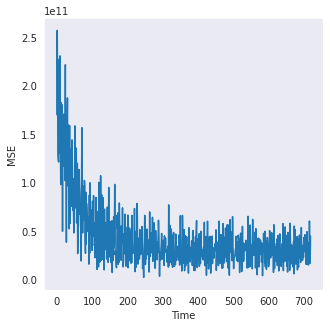

Mean square error on test 820304155254707.2 

Fold: 2 training loss


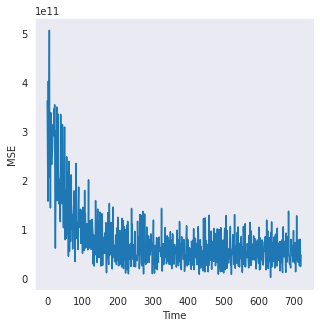

Mean square error on test 1218744532852912.5 

Fold: 3 training loss


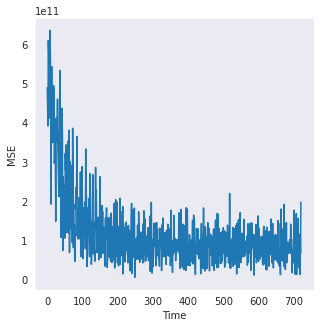

Mean square error on test 879267181996503.8 

Fold: 4 training loss


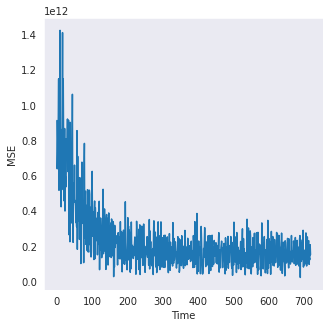

Mean square error on test 3039950673561283.0 

Fold: 5 training loss


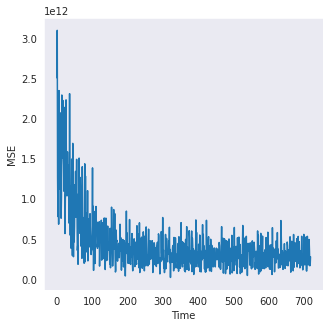

Mean square error on test 9308565885788402.0 

Fold: 6 training loss


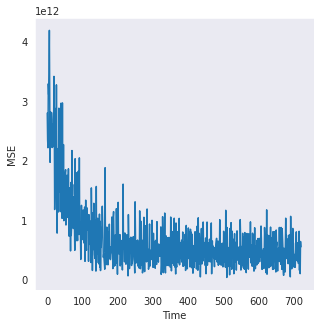

Mean square error on test 3914549937995185.5 

Fold: 7 training loss


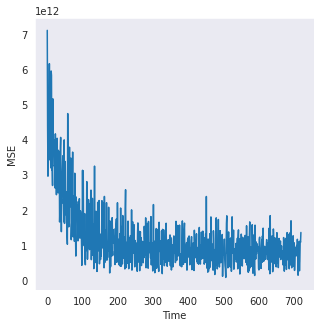

Mean square error on test 3.133046363740936e+16 

Fold: 8 training loss


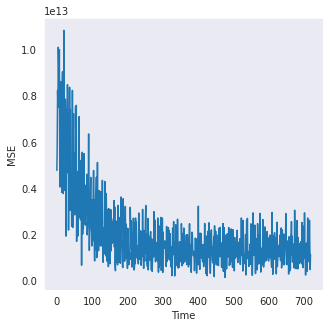

Mean square error on test 3.0726630243651616e+16 

Fold: 9 training loss


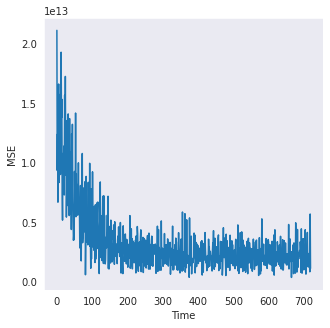

Mean square error on test 2.895797708313323e+16 

Fold: 10 training loss


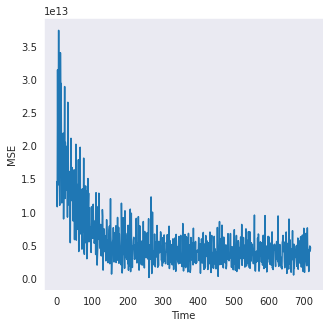

Mean square error on test 1.952636200662016e+17 



Average mean square error after 10 folds: 3.054600733978448e+16


In [22]:
#minibatch
avg_mean_sq = 0
c = 0
fld = 0

for train_index, test_index in kf.split(dfm):
    fld += 1
    pat_train_set = dfm.loc[train_index] #training data
    pat_test_set = dfm.loc[test_index] #test data
    from sklearn import preprocessing
    fminMax = preprocessing.MinMaxScaler()
    tminMax = preprocessing.MinMaxScaler()
    xFeatures = fminMax.fit_transform(pat_train_set.drop('satisfaction',axis='columns'))
    yTarget = tminMax.fit_transform(pat_train_set['satisfaction'].values.reshape(pat_train_set.shape[0],1))
    yTarget = yTarget.reshape(yTarget.shape[0],)
    learning_rate = 0.01
    bais,weight,clst= minibatch_gd(xFeatures,yTarget,learning_rate,120,7)
    lst = list(range(len(clst)))
    print("Fold:", fld, "training loss")
    plt.figure(figsize=(5,5))
    plt.ylabel('MSE')
    plt.xlabel('Time')
    plt.plot(lst,clst)
    plt.show()
    
    for test_pred in pat_test_set.values:
        mean_sq = []
        pred = predict_trgt(test_pred[1], test_pred[2], test_pred[3],weight,bais)
        m_err = (test_pred[0] - pred) ** 2
        mean_sq.append(m_err)
    mse = sum(mean_sq)/len(pat_test_set)
    avg_mean_sq += mse
    print("Mean square error on test", mse, "\n")
    c+=1
print("\n")   
print("Average mean square error after 10 folds:",avg_mean_sq/c)

We tried hard coded learning rates. The range of learning rates was 0.001 to 0.1 and we also experimented with the learning rates of 0.005 as well. For batch and mini-batch gradient descent, we found that 0.1 is the optimal learning rate. Also we selected the learning rate by minimizing mean square error in each iteration. 

As we can see from the above calculations mse are almost close in all cases expect few folds.

After testing all three gradient descent, batch gradient descent and minibatch gradient descent are doing good when compared to stochastic gradient descent and the mean square error for both batch gradient descent and minibatch gradient descent are almost same. In batch and minibatch gradient descent, we compute the gradient of the cost function with respect to each parameter. Due to the randomness in the stochastic gradient descent, the cost function did not settle and even with smaller learning rate, it is difficult to find the global minimum.